# Colapse all simulation into a unique .feather file

In [1]:
import glob, os
import pandas as pd
import numpy as np
from scipy.stats import ecdf, wasserstein_distance

df_complete_file = 'df_complete_ex3.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_complete_file) ):
    print(f'{df_complete_file} already exists. Reading it.')
    df_all = pd.read_feather(df_complete_file)
else:
    print(f'{df_complete_file} does not exists. Generating it.')
    data_files = glob.glob('../output_SA_ex3/SummaryFile_*.feather')
    df_all = pd.concat((pd.read_feather(file) for file in data_files), ignore_index=True)
    # Add the new column with parameter value to IC immune fraction
    df_all['IC_immune_frac'] = 1
    # Define the values to be assigned to samples 1-8 with diff IC proportions
    immune_frac_values = [0.99, 1.01, 0.95, 1.05, 0.9,1.1, 0.8, 1.2]
    # Assign the values to the corresponding samples
    for i, value in enumerate(immune_frac_values, start=1):
        df_all.loc[df_all['sample'] == i, 'IC_immune_frac'] = value

    # Save the dataframe to a feather file
    df_all.to_feather(df_complete_file)

params_list = ['phago_rate_apop', 'phago_rate_nec', 'mac_antinf_secretion_base',
       'attack_duration', 'cd8_migr_speed_base', 'damage_apop_sat',
       'damage_apop_hfm', 'damage_apop_hp', 'dead_debris_sat',
       'dead_debris_hfm', 'dead_debris_hp', 'mac_oxy_proinf_sat',
       'mac_oxy_proinf_hfm', 'mac_oxy_proinf_hp', 'mac_oxy_antinf_hfm',
       'mac_oxy_antinf_hp', 'cd8_antinf_attack_hfm', 'cd8_antinf_attack_hp',
       'cd8_proinf_attack_sat', 'cd8_proinf_attack_hfm',
       'cd8_proinf_attack_hp', 'cd8_antinf_speed_hfm', 'cd8_antinf_speed_hp',
       'cd8_contact_speed_hfm', 'cd8_contact_speed_hp', 'IC_immune_frac']

df_all # 252890 rows = 209 samples * 10 repplicates * 121 time points 

df_complete_ex3.feather already exists. Reading it.


,time,replicate,sample,runtime,tumor_live,tumor_apop,tumor_nec,macrophage,CD8 T cell,dist_tumor_live,...,cd8_antinf_attack_hfm,cd8_antinf_attack_hp,cd8_proinf_attack_sat,cd8_proinf_attack_hfm,cd8_proinf_attack_hp,cd8_antinf_speed_hfm,cd8_antinf_speed_hp,cd8_contact_speed_hfm,cd8_contact_speed_hp,IC_immune_frac
0,0.0,4,107,0.000020,2000,0,0,100,100,"[358.0477958719171, 368.6989851084816, 234.545...",...,0.5,8.0,1.0,0.5,8.0,0.5,8.00,0.5,8.0,1.0
1,60.0,4,107,1.475843,2033,8,44,100,100,"[355.16957725645756, 368.5698984495574, 236.40...",...,0.5,8.0,1.0,0.5,8.0,0.5,8.00,0.5,8.0,1.0
2,120.0,4,107,2.937030,1992,9,98,100,100,"[355.86460944309357, 369.71805686326286, 232.1...",...,0.5,8.0,1.0,0.5,8.0,0.5,8.00,0.5,8.0,1.0
3,180.0,4,107,4.401384,1959,13,136,100,100,"[356.51606386094113, 370.78878927427206, 229.6...",...,0.5,8.0,1.0,0.5,8.0,0.5,8.00,0.5,8.0,1.0
4,240.0,4,107,5.874779,1933,18,173,100,100,"[356.6679818433615, 371.4661757015087, 227.939...",...,0.5,8.0,1.0,0.5,8.0,0.5,8.00,0.5,8.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252885,6960.0,8,185,137.477204,780,21,0,100,100,"[408.0463230513623, 442.5102587035708, 389.323...",...,0.5,8.0,1.0,0.5,8.0,0.5,7.92,0.5,8.0,1.0
252886,7020.0,8,185,138.524205,784,25,0,100,100,"[407.3665239500313, 442.4090940790859, 388.939...",...,0.5,8.0,1.0,0.5,8.0,0.5,7.92,0.5,8.0,1.0
252887,7080.0,8,185,139.576409,791,25,0,100,100,"[407.38948659632456, 443.9188603650407, 388.51...",...,0.5,8.0,1.0,0.5,8.0,0.5,7.92,0.5,8.0,1.0
252888,7140.0,8,185,140.632262,802,23,0,100,100,"[408.2742629158863, 442.92683714909106, 388.22...",...,0.5,8.0,1.0,0.5,8.0,0.5,7.92,0.5,8.0,1.0


# Define the QoIs: AUC of tumor mean population, distribution of cell distance from the center at the last time

- Population: store the population of each cell type over time.
    - Summary over time and replicates: Area under curve (AUC) of the average populations.
- Invasion: Distance of cells from the center - provides insights into the spatial distribution and invasion characteristics of the cells.
    - Summary over time and replicates: Pool the distances from replicates and calculate the Wassertein distance between tumor and CD8, and tumor and macrophages.


In [2]:
df_qoi_file = 'df_qoi_ex3.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
df_summary_file = 'df_summary_ex3.feather' # https://pandas.pydata.org/docs/user_guide/io.html#feather
if ( os.path.exists(df_summary_file) & os.path.exists(df_qoi_file) ):
    print(f'{df_summary_file} and {df_qoi_file} already exists. Reading it.')
    df_summary = pd.read_feather(df_summary_file)
    df_qoi = pd.read_feather(df_qoi_file)
else:
    print(f'{df_summary_file} or {df_qoi_file} does not exists. Generating it.')
    # Calculate the AUC for each sample and replicate
    def calculate_auc_wassertein_dist(group):
        auc_values = {}
        for col in ['tumor_live', 'tumor_apop', 'tumor_nec']: # QoI columns of cell population  
            mask_notna = group[col].notna()  
            auc_values[f'AUC_{col}'] = np.trapz(group[col][mask_notna], group['time'][mask_notna])
        wasserstein_values = {}
        subgroup = group[group['time'] == 7200.0] # select the last time point
        emp_tumor_cdf = ecdf(subgroup['dist_tumor'].values[0])
        emp_mac_cdf = ecdf(subgroup['dist_mac'].values[0])
        emp_cd8_cdf = ecdf(subgroup['dist_cd8'].values[0])
        wasserstein_values['Wasserstein_dist_Mac'] = wasserstein_distance(emp_tumor_cdf.cdf.quantiles, emp_mac_cdf.cdf.quantiles, emp_tumor_cdf.cdf.probabilities, emp_mac_cdf.cdf.probabilities)
        wasserstein_values['Wasserstein_dist_CD8'] = wasserstein_distance(emp_tumor_cdf.cdf.quantiles, emp_cd8_cdf.cdf.quantiles, emp_tumor_cdf.cdf.probabilities, emp_cd8_cdf.cdf.probabilities)
        return pd.Series({**auc_values, **wasserstein_values})
    # Concatenate the dist_tumor_live and dist_tumor_apop and dist_tumor_nec columns into a single column
    df_all['dist_tumor'] = df_all.apply(lambda row: np.concatenate([row['dist_tumor_live'], row['dist_tumor_apop'], row['dist_tumor_nec']]), axis=1)
    df_all.drop(['dist_tumor_live', 'dist_tumor_apop', 'dist_tumor_nec'], axis=1, inplace=True)
    # Group by 'SampleID' and 'replicate' then calculate AUC and Wassertein distance for each QOI - row dimension of samples x replicates
    df_qoi = df_all.groupby(['sample', 'replicate']).apply(calculate_auc_wassertein_dist).reset_index()
    # Add the parameter values to the QoI dataframe
    df_qoi = df_qoi.merge(df_all[['sample', 'replicate'] + params_list], on=['sample', 'replicate'], how='left').drop_duplicates().reset_index(drop=True)
    
    # Calculate the mean and standard deviation of the QoI for each sample
    df_summary = df_qoi.groupby(['sample']).agg({'AUC_tumor_live': ['mean', 'std'], 'AUC_tumor_apop': ['mean', 'std'], 'AUC_tumor_nec': ['mean', 'std'], 'Wasserstein_dist_Mac': ['mean', 'std'], 'Wasserstein_dist_CD8': ['mean', 'std']}).reset_index()
    df_summary.columns = ['_'.join(col) if col[1] else col[0] for col in df_summary.columns]
    # Add the parameter values to the summary dataframe
    df_summary = df_summary.merge(df_qoi[['sample'] + params_list], on=['sample'], how='left').drop_duplicates().reset_index(drop=True)
    
    # Save the dataframes to feather files
    df_qoi.to_feather(df_qoi_file)
    df_summary.to_feather(df_summary_file)

print(df_qoi.shape)
print(df_summary.shape)
df_summary

df_summary_ex3.feather and df_qoi_ex3.feather already exists. Reading it.
(2090, 33)
(209, 37)


,sample,AUC_tumor_live_mean,AUC_tumor_live_std,AUC_tumor_apop_mean,AUC_tumor_apop_std,AUC_tumor_nec_mean,AUC_tumor_nec_std,Wasserstein_dist_Mac_mean,Wasserstein_dist_Mac_std,Wasserstein_dist_CD8_mean,...,cd8_antinf_attack_hfm,cd8_antinf_attack_hp,cd8_proinf_attack_sat,cd8_proinf_attack_hfm,cd8_proinf_attack_hp,cd8_antinf_speed_hfm,cd8_antinf_speed_hp,cd8_contact_speed_hfm,cd8_contact_speed_hp,IC_immune_frac
0,0,6705909.0,554158.467597,338649.0,20730.026773,1559958.0,94583.965026,120.371803,15.959334,222.268921,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,8.0,1.00
1,1,6714348.0,661527.123737,329511.0,26469.197381,1536687.0,97353.167848,120.560999,14.141265,213.256247,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,8.0,0.99
2,2,6814764.0,332959.444317,331635.0,21746.541104,1547763.0,81676.290868,118.837579,12.580831,220.690060,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,8.0,1.01
3,3,7007265.0,495115.343380,339615.0,15819.742413,1536255.0,88807.335564,114.603822,12.286489,202.861119,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,8.0,0.95
4,4,6723822.0,333683.900481,323328.0,23181.605639,1547901.0,101704.648910,112.584886,16.791061,207.144209,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,8.0,1.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,204,6733563.0,441384.176982,320136.0,17973.234545,1545426.0,76493.092237,120.009796,13.048864,203.364394,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,8.4,1.00
205,205,6327156.0,527285.300535,309393.0,12941.348075,1554654.0,81943.099526,111.790704,17.380849,224.129107,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,7.2,1.00
206,206,6955878.0,350535.487847,337536.0,14942.896640,1578612.0,79678.357413,117.577872,12.748025,223.975451,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,8.8,1.00
207,207,6528447.0,211323.359546,314406.0,12108.226955,1503630.0,81957.780595,118.868191,16.683466,214.104834,...,0.5,8.0,1.0,0.5,8.0,0.5,8.0,0.5,6.4,1.00


# Local sensitivity analysis: 
Give $\theta^\star$ as the reference parameter set, we added a multiplicative perturbation $\delta$, which
$$\theta_i = \theta^\star \times (1\pm \delta), \quad \delta = \{0.01, 0.05, 0.1, 0.2\}$$

Absolute sensitivity (A unit increase in $\theta_i$ changes the output by $S_{\theta_i}$ units): 
$$S_{\theta_i} = \dfrac{f(\theta_i)-f(\theta^\star)}{\theta_i - \theta^\star}$$
Relative sensitivity (Elasticity -  For every $1\%$ change in $\theta_i$, the output changes by $\bar{S}_{\theta_i} \times 1\%$:

$$\bar{S}_{\theta_i} = \dfrac{f(\theta_i)-f(\theta^\star)}{\theta_i - \theta^\star}\cdot \dfrac{\theta^\star}{f(\theta^\star)}$$

- $S>0:$ As the parameter increases, the output also increases.
- $S<0:$ As the parameter increases, the output decreases.
- $S=0:$ The output is insensitive to changes in the parameter.
- $∣S∣≫1:$ The output is highly sensitive to the parameter; small changes in the parameter will cause large changes in the output.
- $∣S∣≪1:$ The output is relatively insensitive to the parameter; large changes in the parameter will have little effect on the output.

In [3]:
sample_ref = 0 # Sample with reference parameters
print('Sample with reference parameters: ', df_summary.iloc[sample_ref][params_list].values)

# Calculate the sensitivity index
QoIs_list = ['AUC_tumor_live_mean', 'AUC_tumor_apop_mean', 'AUC_tumor_nec_mean', 'Wasserstein_dist_Mac_mean', 'Wasserstein_dist_CD8_mean']
# Function to calculate SI using
def calculate_SI_multiple():
    sensitivity_analysis_dic = {}
    # Calculate the delta of parameters
    non_zero_values = []; non_zero_params= []
    relative_change_params = (df_summary[params_list] - df_summary.iloc[sample_ref][params_list].values) / np.where(df_summary.iloc[sample_ref][params_list].values != 0, df_summary.iloc[sample_ref][params_list].values, 1)
    for index, row in relative_change_params.iterrows():
        # First index is the reference sample - include the value 1 and skip it
        if index == sample_ref: non_zero_values.append(1); non_zero_params.append(params_list[0]); continue
        # Get the non-zero values in the row
        non_zero_row_values = row[row != 0.0]
        # Check if there is exactly one non-zero value
        if len(non_zero_row_values) == 1: non_zero_values.append(non_zero_row_values.iloc[0])
        else: raise ValueError(f"Row {index} contains more than one non-zero value or all values are zero. Non zero: {non_zero_row_values} - Row: {row.values}")
        # Parameter name with non-zero value
        non_zero_params.append(non_zero_row_values.index[0])
    relative_change_params_1d = pd.DataFrame(non_zero_values, columns=['NonZeroValues'])
    sensitivity_analysis_dic['SA_parameter'] = np.array(non_zero_params)
    sensitivity_analysis_dic['SA_delta'] = relative_change_params_1d.to_numpy()[:,0].round(2)
    # Calculate the delta of QoIs
    absolute_change_qois = df_summary[QoIs_list] - df_summary.iloc[sample_ref][QoIs_list].values
    relative_change_qois = absolute_change_qois / np.where(df_summary.iloc[sample_ref][QoIs_list].values != 0, df_summary.iloc[sample_ref][QoIs_list].values, 1)
    absolute_change_params = sensitivity_analysis_dic['SA_delta'] * df_summary.iloc[sample_ref][ sensitivity_analysis_dic['SA_parameter'] ].to_numpy()
    for id_qoi, qoi in enumerate(QoIs_list): 
        sensitivity_analysis_dic[f'SI_{qoi}'] = relative_change_qois.to_numpy()[:,id_qoi]/sensitivity_analysis_dic['SA_delta']
        parameter_name = sensitivity_analysis_dic['SA_parameter']
        sensitivity_analysis_dic[f'Abs_SI_{qoi}'] = absolute_change_qois.to_numpy()[:,id_qoi]/absolute_change_params
    
    # Change the delta of reference value to 0 and label it as reference
    sensitivity_analysis_dic['SA_delta'][0] = 0
    sensitivity_analysis_dic['SA_parameter'][0] = 'Reference'
    return pd.DataFrame(sensitivity_analysis_dic)

# Group by 'Sample_ID' then calculate AUC for each QOI - row dimension of samples
df_SA = calculate_SI_multiple() # calculate the AUC for each QOI
df_SA = pd.concat([df_summary['sample'], df_SA], axis=1)

# Print the sensitivity index
for qoi in QoIs_list:
    sample_lowest_qoi = df_summary.iloc[df_summary[qoi].idxmin()]['sample']; sample_highest_qoi = df_summary.iloc[df_summary[qoi].idxmax()]['sample']
    sample_lowest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmin()]['sample']; sample_highest_si = df_SA.iloc[df_SA[f'SI_{qoi}'].idxmax()]['sample']
    print(f"QoI: {qoi}")
    print(f"\t lowest and highest QoI: {sample_lowest_qoi} ({df_SA.iloc[int(sample_lowest_qoi)]['SA_parameter']}) and {sample_highest_qoi} ({df_SA.iloc[int(sample_highest_qoi)]['SA_parameter']})")
    print(f"\t lowest and highest SI: {sample_lowest_si} ({df_SA.iloc[int(sample_lowest_si)]['SA_parameter']}) and {sample_highest_si} ({df_SA.iloc[int(sample_highest_si)]['SA_parameter']})\n")
df_SA

Sample with reference parameters:  [1.0e-01 1.7e-02 1.0e+01 1.5e+01 1.0e+00 2.3e-02 4.5e+01 1.6e+01 1.7e-02
 1.0e-01 1.0e+01 1.0e+01 5.0e+00 4.0e+00 5.0e+00 4.0e+00 5.0e-01 8.0e+00
 1.0e+00 5.0e-01 8.0e+00 5.0e-01 8.0e+00 5.0e-01 8.0e+00 1.0e+00]
QoI: AUC_tumor_live_mean
	 lowest and highest QoI: 48.0 (cd8_migr_speed_base) and 47.0 (cd8_migr_speed_base)
	 lowest and highest SI: 10 (phago_rate_apop) and 129 (mac_oxy_antinf_hp)

QoI: AUC_tumor_apop_mean
	 lowest and highest QoI: 205.0 (cd8_contact_speed_hp) and 75.0 (dead_debris_sat)
	 lowest and highest SI: 82 (dead_debris_hfm) and 73 (dead_debris_sat)

QoI: AUC_tumor_nec_mean
	 lowest and highest QoI: 48.0 (cd8_migr_speed_base) and 47.0 (cd8_migr_speed_base)
	 lowest and highest SI: 74 (dead_debris_sat) and 145 (cd8_antinf_attack_hp)

QoI: Wasserstein_dist_Mac_mean
	 lowest and highest QoI: 144.0 (cd8_antinf_attack_hfm) and 83.0 (dead_debris_hfm)
	 lowest and highest SI: 66 (damage_apop_hp) and 97 (mac_oxy_proinf_sat)

QoI: Wasserstein

,sample,SA_parameter,SA_delta,SI_AUC_tumor_live_mean,Abs_SI_AUC_tumor_live_mean,SI_AUC_tumor_apop_mean,Abs_SI_AUC_tumor_apop_mean,SI_AUC_tumor_nec_mean,Abs_SI_AUC_tumor_nec_mean,SI_Wasserstein_dist_Mac_mean,Abs_SI_Wasserstein_dist_Mac_mean,SI_Wasserstein_dist_CD8_mean,Abs_SI_Wasserstein_dist_CD8_mean
0,0,Reference,0.00,0.000000,0.000000e+00,0.000000,0.000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,1,IC_immune_frac,-0.01,-0.125844,-8.439000e+05,2.698369,913800.000,1.491771,2327100.0,-0.157177,-18.919656,4.054851,901.267380
2,2,IC_immune_frac,0.01,1.623270,1.088550e+07,-2.071171,-701400.000,-0.781752,-1219500.0,-1.274571,-153.422359,-0.710338,-157.886016
3,3,IC_immune_frac,-0.05,-0.898777,-6.027120e+06,-0.057050,-19320.000,0.303893,474060.0,0.958361,115.359620,1.746335,388.156034
4,4,IC_immune_frac,0.05,0.053425,3.582600e+05,-0.904831,-306420.000,-0.154581,-241140.0,-1.293811,-155.738344,-1.360938,-302.494228
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,204,cd8_contact_speed_hp,0.05,0.082477,6.913500e+04,-1.093344,-46282.500,-0.186313,-36330.0,-0.060148,-0.905016,-1.701050,-47.261316
205,205,cd8_contact_speed_hp,-0.10,0.564805,4.734412e+05,0.863903,36570.000,0.034001,6630.0,0.712883,10.726373,-0.083691,-2.325233
206,206,cd8_contact_speed_hp,0.10,0.372759,3.124612e+05,-0.032866,-1391.250,0.119580,23317.5,-0.232108,-3.492414,0.076778,2.133162
207,207,cd8_contact_speed_hp,-0.20,0.132318,1.109138e+05,0.357937,15151.875,0.180543,35205.0,0.062457,0.939757,0.183653,5.102554


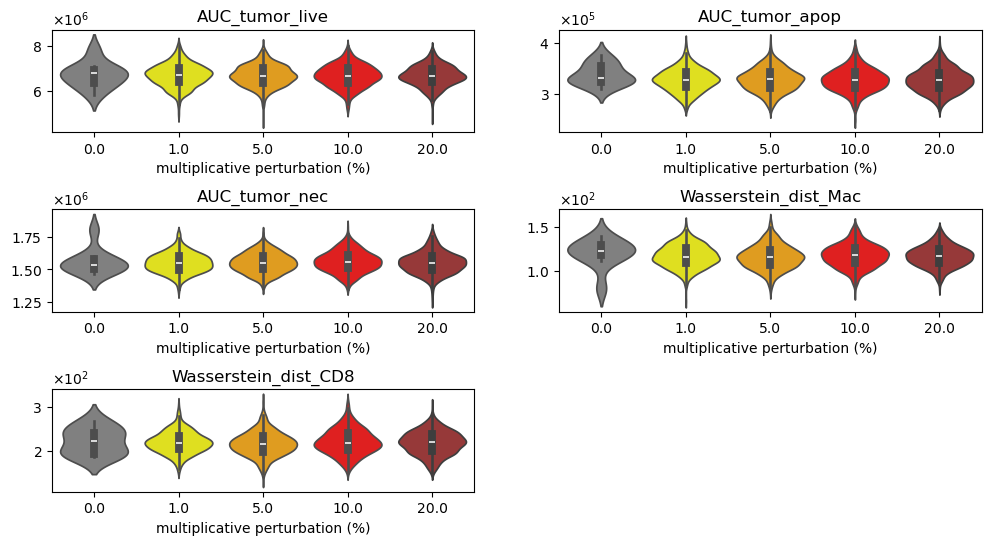

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 2, figsize=(12, 6))
plt.subplots_adjust(hspace=0.75)
for qoi, ax in zip(QoIs_list, axes.flatten()):
    # Plot a box plot for each QoI (x axis: SA_delta, y axis: QoI value)
    # ax.boxplot([df_all[df_summary['sample'] == sample][qoi].values for sample in [sample_ref, *samples_deltap1, *samples_deltam1, *samples_deltap5, *samples_deltam5, *samples_deltap10, *samples_deltam10, *samples_deltap20, *samples_deltam20]], showfliers=False)
    for delta, color in zip([0.0, 0.01, 0.05, 0.1, 0.2], 
                            ['gray', 'yellow', 'orange', 'red', 'brown']):
        samples = df_SA[ (df_SA['SA_delta'] == delta) | (df_SA['SA_delta'] == -1*delta) ]['sample'].values
        # print(delta, samples)
        values = df_qoi[df_qoi['sample'].isin(samples)][qoi[:-5]].values
        sns.violinplot(x=[delta*100]*len(values), y=values, ax=ax, color=color)
    
    ax.set_title(qoi[:-5])
    ax.set_xlabel('multiplicative perturbation (%)')
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.yaxis.major.formatter._useMathText = True
axes[2, 1].remove()
# plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5))


plt.show()

/var/folders/z0/qjtn97gj62z2_f7wmwlwkvmc0000gn/T/ipykernel_5393/3772429495.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SA["SA_delta"] = df_SA["SA_delta"] * 100


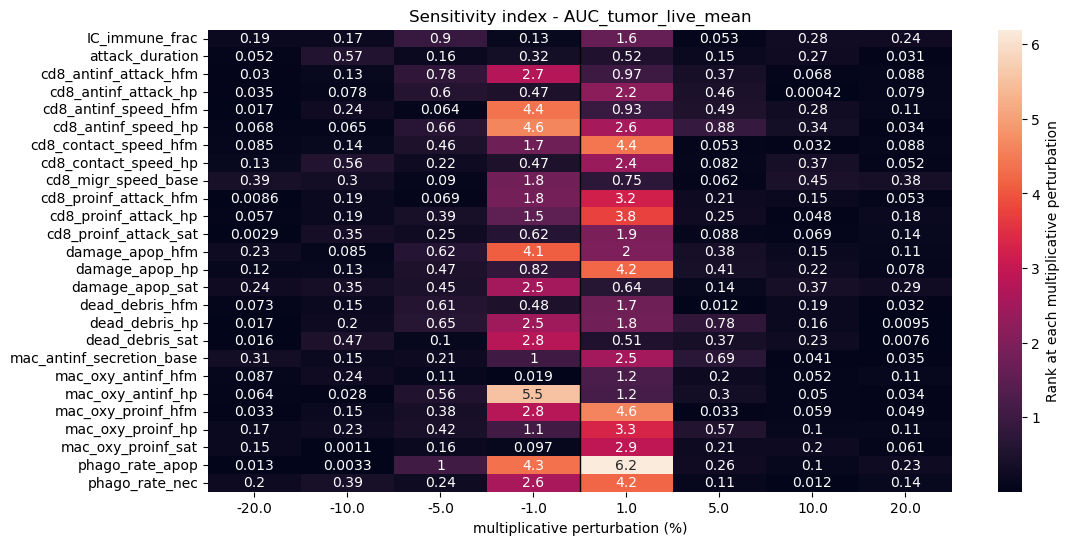

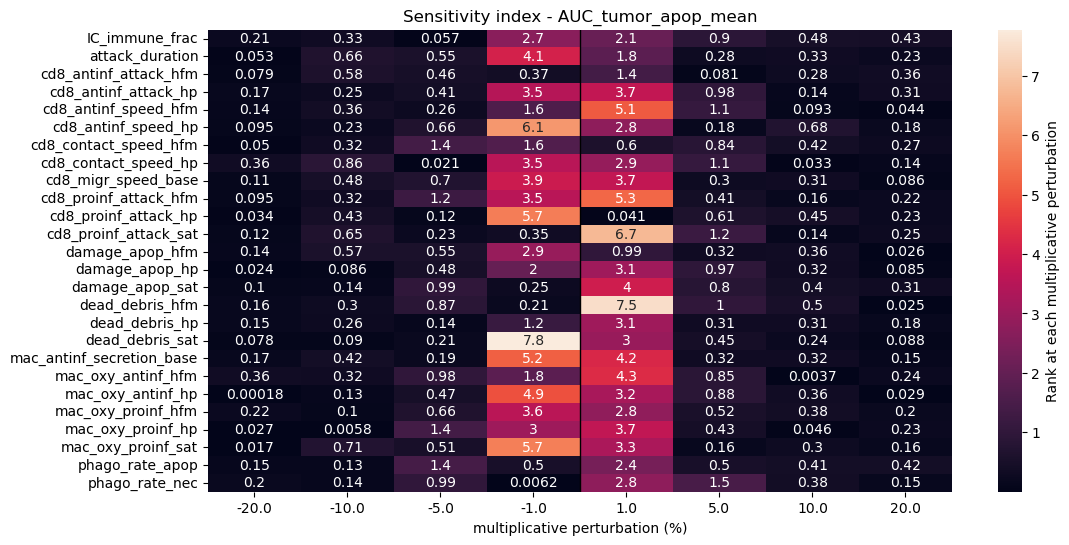

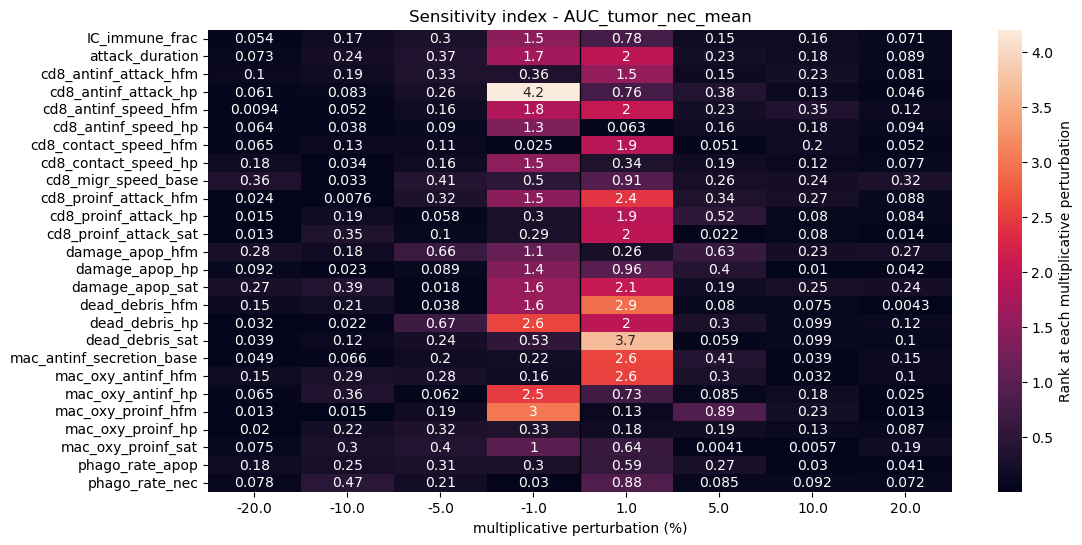

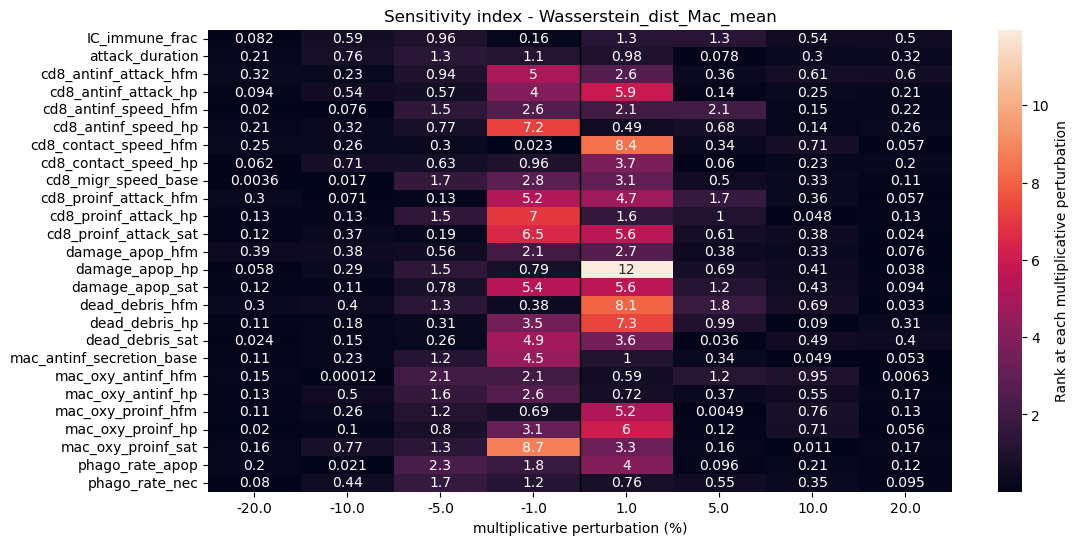

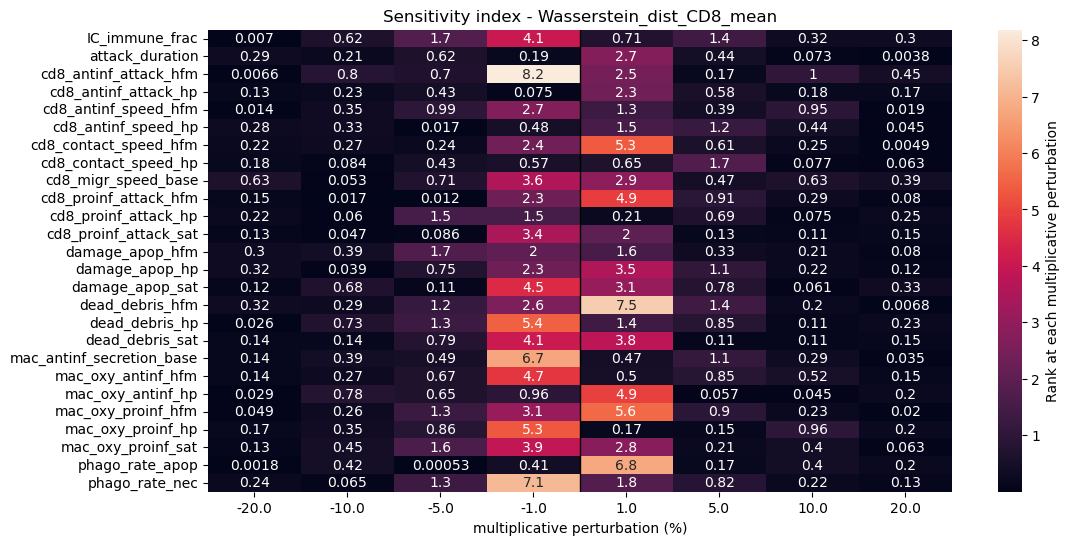

In [ ]:
# Drop the reference sample
df_SA = df_SA[df_SA['sample'] != sample_ref]
# Convert the multiplicative perturbation to percentage and absolute values
df_SA["SA_delta"] = df_SA["SA_delta"].abs() * 100
plot = 'Abs_SI' # plot_options =  ["SI", "Abs_SI", 'Rank']
# Plot the parameter rank according to the relatice sensitivity index as heatmap with the parameters vs delta and color as the rank
for qoi in QoIs_list:
    fig, ax = plt.subplots(figsize=(12, 6))
    if plot == 'SI':
        # pivot the dataframe to have the parameter as index, delta as columns and sensitivity index as values
        df_SA_pivot_plot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi)
    if plot == 'Abs_SI':
        # pivot the dataframe to have the parameter as index, delta as columns and absolute sensitivity index as values
        df_SA_pivot_plot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi).abs()
    if plot == 'Rank':
        df_SA_pivot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi).abs()
        # rank of each parameter for each multiplicative perturbation ( 1 - highest sensitivity, 2 - second highest sensitivity, etc)
        df_SA_pivot_plot = df_SA_pivot.rank(axis=0, method='min', ascending=False)

    # print(df_SA_pivot.head(),'\n')
    # print(df_SA_pivot_rank.head(),'\n')
    # 
    sns.heatmap(df_SA_pivot_plot, cmap='rocket', annot=True,ax=ax)
    cbar = ax.collections[0].colorbar
    cbar.set_label('Rank at each multiplicative perturbation')
    # draw a line to separate the positive and negative values
    ax.axvline(4, color='black', lw=1)
    ax.set(title = f'Sensitivity index - {qoi}', xlabel='multiplicative perturbation (%)', ylabel=None)
plt.show()

# Calculate the Normalized SI in each multiplicative perturbation
$$ Normalize SI_{i,j} = \frac{SI_{i,j}}{\max SI_{.,j}},$$

where $S_{i,j}$ is the sensitivity index in each parameter $i$ and multiplicative pertubation $j$


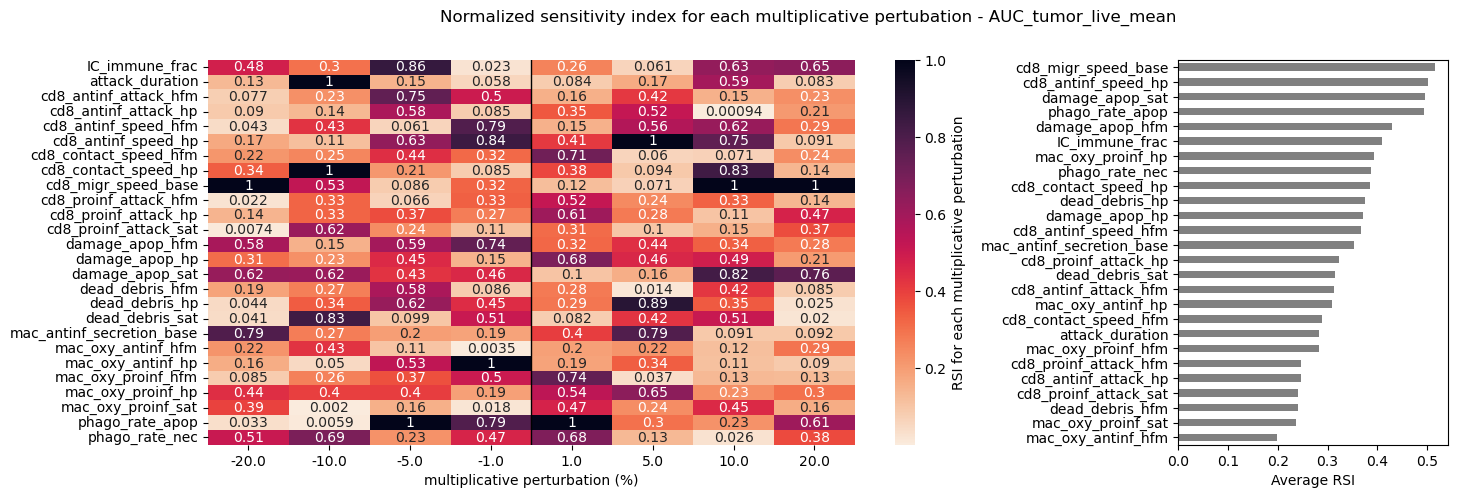

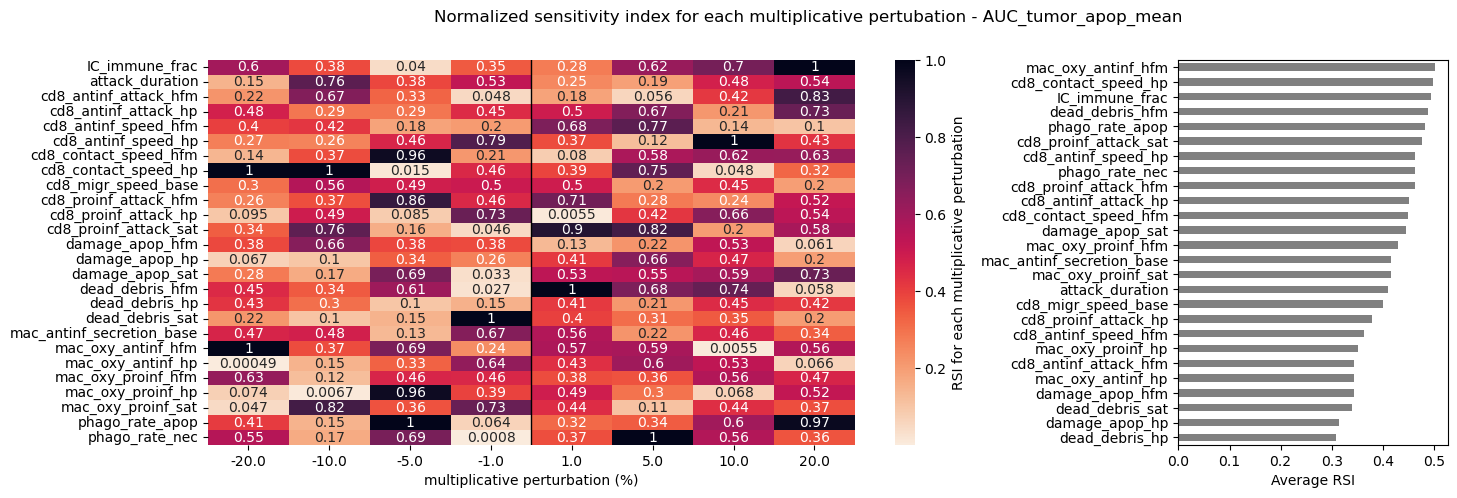

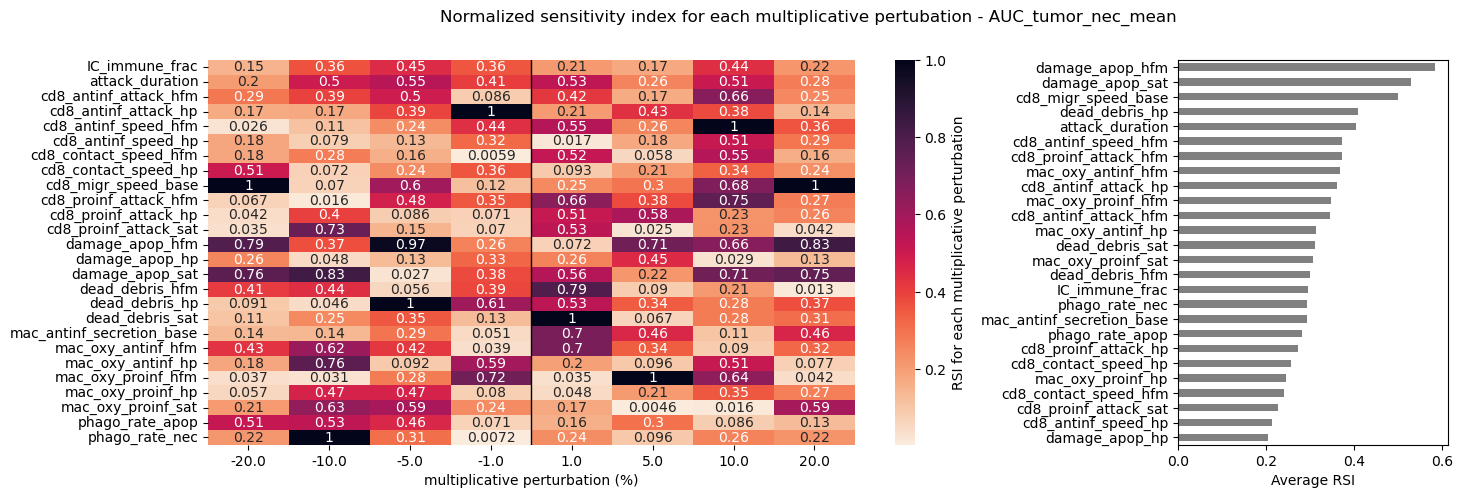

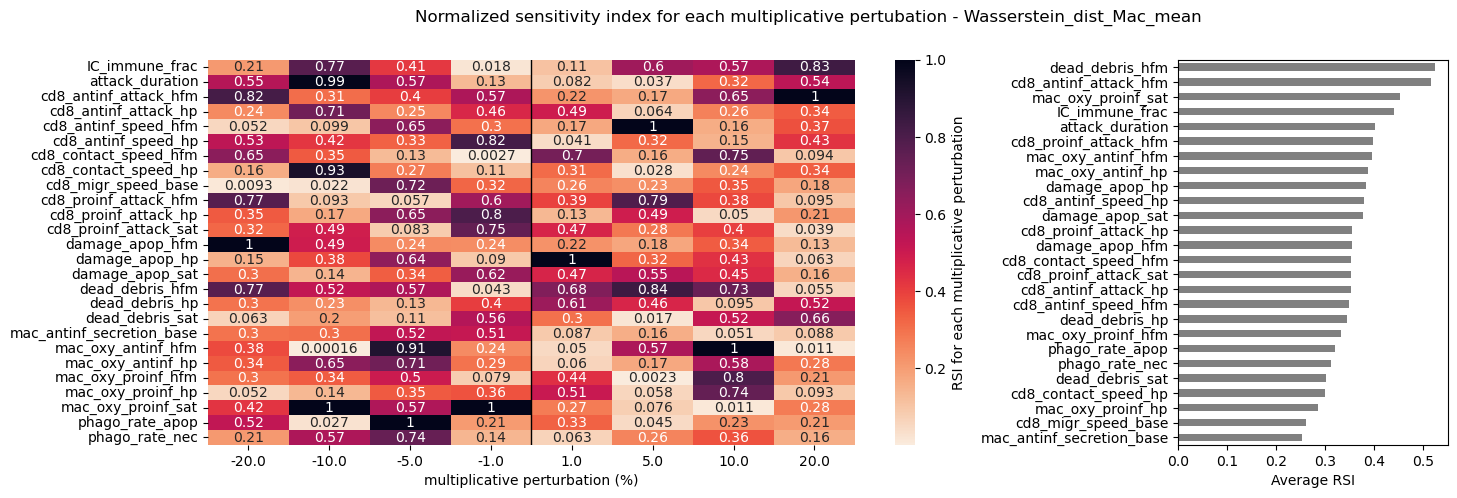

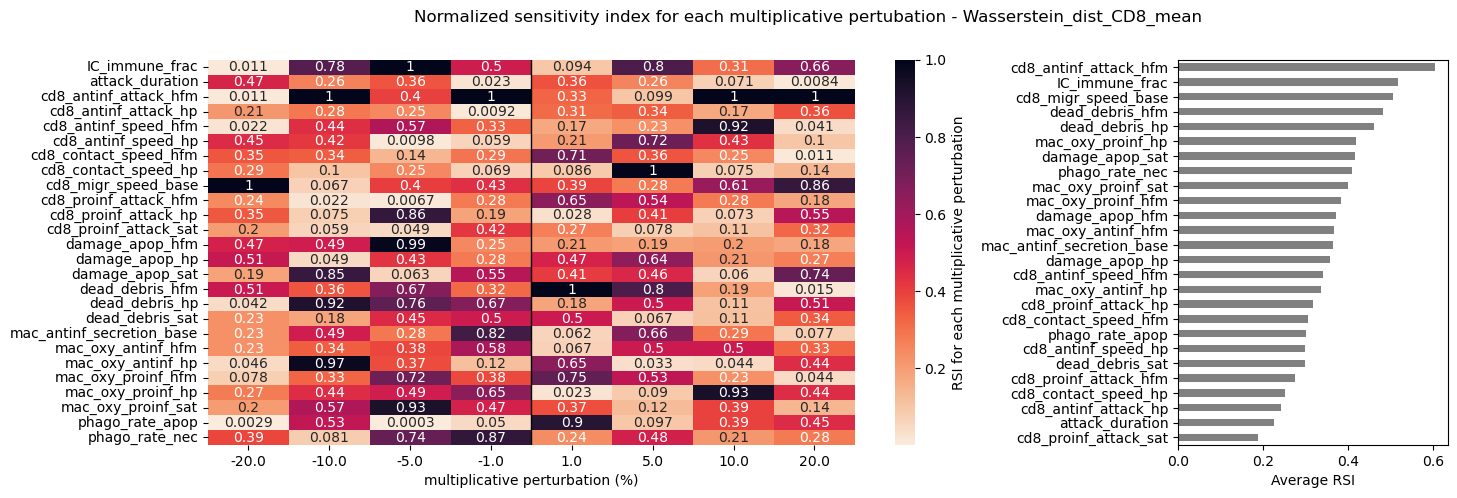

In [6]:
for qoi in QoIs_list:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), gridspec_kw={'width_ratios': [3, 1]})
    plt.subplots_adjust(wspace=0.3)
    fig.suptitle(f'Normalized sensitivity index for each multiplicative pertubation - {qoi}')
    # Round the values to 2 decimal places
    # df_SA['SA_delta'] = df_SA['SA_delta'].round(2)
    df_SA_pivot = df_SA.pivot(index="SA_parameter", columns="SA_delta", values="SI_"+qoi).abs()
    # df of the rank of each parameter for each multiplicative perturbation
    # df_SA_pivot_rank = df_SA_pivot.rank(axis=0, method='min', ascending=False)
    # convert the rank to rank sensitivity index
    # df_SA_pivot_RSI = (df_SA_pivot_rank.shape[0] - df_SA_pivot_rank) / (df_SA_pivot_rank.shape[0] - 1)
    df_SA_pivot_RSI = df_SA_pivot / df_SA_pivot.max()
    sns.heatmap(df_SA_pivot_RSI, cmap='rocket_r', annot=True,ax=ax1)
    cbar = ax1.collections[0].colorbar
    cbar.set_label('RSI for each multiplicative perturbation')
    ax1.set(xlabel='multiplicative perturbation (%)', ylabel=None)
    # draw a line to separate the positive and negative values
    ax1.axvline(4, color='black', lw=1)
    # Average the RSI across all multiplicative perturbations
    df_rsi_mean = df_SA_pivot_RSI.mean(axis=1)
    df_rsi_mean = df_rsi_mean.sort_values(ascending=True)
    df_rsi_mean.plot(kind='barh', ax=ax2, color='gray')
    ax2.set(xlabel='Average RSI', ylabel=None)

 

# Interpretation of results

The local SA does not show clear interpretation, the parameters importance rank changes drastically according the multiplicative perturbation. This coudl be related to the nonlinear behavior: the sensitivity of the output can change depending on the magnitude of the parameters, local vs global: different parameters might dominate at different scales, interactions between the parameters might become more pronounced.
